## 1. Fast Agent - Build a SQL Agent Fast!

<div style="text-align: right"> Initial issue : 2025.11.05 </div>
<div style="text-align: right"> last update : 2025.11.05 </div>

<img src="./assets/LC_L1_top.png" align="left" width="500">

In [1]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs
load_dotenv()

True

In [2]:
# Check and print results
doublecheck_env("example.env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

OPENAI_API_KEY=****7t4A
LANGSMITH_API_KEY=<not set>
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
ERROR: pyproject.toml not found.


In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [5]:
db.get_table_names()

/var/folders/b1/hn_q_ymx6dzg3_kxyzp34xbm0000gn/T/ipykernel_35242/4073026401.py:1: LangChainDeprecationWarning: The method `SQLDatabase.get_table_names` was deprecated in langchain-community 0.0.1 and will be removed in 1.0. Use `get_usable_table_names` instead.
  db.get_table_names()


['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

Runtime context 정의: 에이전트와 도구가 db에 접근하도록 하기 위함

In [6]:
from dataclasses import dataclass

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

In [7]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

즉, runtime이란, 에이전트가 실행되는 동안 필요한 공유 상태나 리소스를 관리하는 실행 환경.  
데이터베이스 연결, 설정 값, API 클라이언트 등 여러가지 도구들이 공통으로 사용해야하는 자원을 담고 있음.   

일종의 의존성 주입(Dependency Injection) 메커니즘임.   
에이전트 실행 중에 필요한 공유 자원(DB 연결, API 클라이언트, 설정값 등)을 깔끔하게 전달하는 방법임   

tool 접근은 get_runtime(RuntimeContext)로 주입된 context 가져오기 가능  
여기서는 runtime.context.db로 주입받은 db 접근 가능

이제 시스템 프롬프트를 정의한다.

In [8]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

에이전트 생성

In [9]:
from langchain.agents import create_agent

agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

ReAct Loop 디스플레이

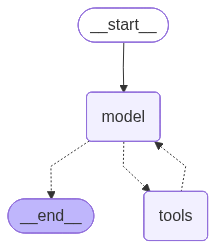

In [10]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

쿼리 실행
- 에이전트는 데이터베이스 스키마를 가지고 있지 않으므로 독립적으로 발견해야 함.
- 에이전트는 실수를 할 수 있음! 에이전트는 오류 메시지를 반환함으로써 쿼리를 자체 수정할 수 있음.
- 에이전트를 `agent.stream`으로 호출한다는 점에 유의하세요.
    - 이 명령어와 `pretty_print`는 모델과 도구 간 정보를 전달하는 **메시지**를 표시합니다.
- 에이전트는 호출 간 스키마를 기억하지 않습니다... 이에 대해서는 나중에 자세히 설명하겠습니다!

In [11]:
question = "어떤 테이블이 가장 많은 항목을 가지고 있나요?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

어떤 테이블이 가장 많은 항목을 가지고 있나요?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_WWVJYtok5rt2r83gtEt6Tcxt)
 Call ID: call_WWVJYtok5rt2r83gtEt6Tcxt
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_mJ1qe3eWwrbtV2q7CGGI5kd1)
 Call ID: call_mJ1qe3eWwrbtV2q7CGGI5kd1
  Args:
    query: SELECT table_name, row_count FROM (
  SELECT 'Album' AS table_name, COUNT(*) AS row_count FROM Album
  UNION ALL
  SELECT 'Artist', COUNT(

In [12]:
question = "평균적으로 어떤 장르가 가장 긴 트랙을 가지고 있나?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

평균적으로 어떤 장르가 가장 긴 트랙을 가지고 있나?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_yoZsAr3rueGFEzhHhG9CWXV5)
 Call ID: call_yoZsAr3rueGFEzhHhG9CWXV5
  Args:
    query: SELECT g.Name AS genre, ROUND(AVG(t.Milliseconds)/1000.0,2) AS avg_seconds, ROUND(AVG(t.Milliseconds)/60000.0,2) AS avg_minutes, COUNT(t.TrackId) AS track_count
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY AVG(t.Milliseconds) DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: genres
[SQL: SELECT g.Name AS genre, ROUND(AVG(t.Milliseconds)/1000.0,2) AS avg_seconds, ROUND(AVG(t.Milliseconds)/60000.0,2) AS avg_minutes, COUNT(t.TrackId) AS track_count
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORD